## Question 1

In [ ]:
import requests
import uuid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from rouge import Rouge
from minsearch import Index
from minsearch import VectorSearch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
from sentence_transformers import SentenceTransformer

sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
ground_truth = df_ground_truth.to_dict(orient='records')

In [3]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [4]:
# Minsearch Index with boosting
index = Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course"]
)
index.fit(documents)

# Boosting parameters
boost_dict = {"question": 1.5, "section": 0.1}

# Search function
def search_function(q):
    return index.search(q["question"], boost_dict=boost_dict, num_results=5)

# Evaluate
results = evaluate(ground_truth, search_function)
results

100%|██████████| 4627/4627 [00:13<00:00, 347.49it/s]


{'hit_rate': 0.8013831856494489, 'mrr': 0.6818312801671366}

## Question 2

In [5]:
texts = []

for doc in documents:
    t = doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [6]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [7]:
# New search function
def search_function_new(q):
    x = pipeline.transform([q["question"]])
    return vindex.search(x[0], num_results=5)

# Run evaluation
results = evaluate(ground_truth, search_function_new)
results

100%|██████████| 4627/4627 [00:06<00:00, 700.02it/s]


{'hit_rate': 0.39377566457748003, 'mrr': 0.2900259347309274}

## Question 3

In [8]:
# Create embeddings using "question + text"
texts = [doc["question"] + " " + doc["text"] for doc in documents]

X = pipeline.fit_transform(texts)

# Create and fit vector search index
vindex = VectorSearch(keyword_fields=["course"])
vindex.fit(X, documents)

In [9]:
# Define search function
def search_function_3(q):
    query_text = q["question"]
    x = pipeline.transform([query_text])
    return vindex.search(x[0], num_results=5)

# Run evaluation
results = evaluate(ground_truth, search_function_3)
results

100%|██████████| 4627/4627 [00:06<00:00, 677.51it/s]


{'hit_rate': 0.7704776312945754, 'mrr': 0.6157661551761406}

## Question 4

In [ ]:
# Used "all-MiniLM-L6-v2" instead of "jinaai/jina-embeddings-v2-small-en" 
# because it was crashing
model = SentenceTransformer("all-MiniLM-L6-v2") 

In [ ]:
# Create texts and embeddings for indexing
texts = [doc['question'] + ' ' + doc['text'] for doc in documents]
vectors = model.encode(texts, convert_to_numpy=True)

# Initialize Qdrant 
qdrant = QdrantClient(":memory:")  # Use in-memory instance

# Create a collection and upload data
qdrant.recreate_collection(
    collection_name="faq_search",
    vectors_config=VectorParams(size=vectors.shape[1], distance=Distance.COSINE),
)
# Upload points to Qdrant
qdrant.upload_points(
    collection_name="faq_search",
    points=[
        PointStruct(
            id=str(uuid.uuid5(uuid.NAMESPACE_DNS, str(doc["id"]))),  # Convert to UUID
            vector=vec,
            payload={**doc, "original_id": doc["id"]}  # Keep original string ID in payload
        )
        for doc, vec in zip(documents, vectors)
    ]
)

In [ ]:
# New evaluate function for Qdrant
def evaluate(ground_truth, search_function):
    relevance_total = []
    for q in ground_truth:
        doc_id = q["document"]
        results = search_function(q)
        relevance = [d.payload["original_id"] == doc_id for d in results]
        relevance_total.append(relevance)
    return {
        "hit_rate": hit_rate(relevance_total),
        "mrr": mrr(relevance_total),
    }

In [ ]:
# Search function using Qdrant
def search_function(q):
    query = q["question"]
    query_vector = model.encode(query).tolist()

    hits = qdrant.search(
        collection_name="faq_search",
        query_vector=query_vector,
        limit=5
    )
    return hits

# Run evaluation
results = evaluate(ground_truth, search_function)
results

{'hit_rate': 0.9007996542035877, 'mrr': 0.7960593617174567}

## Question 5

In [6]:
# Load local file
df = pd.read_csv("/workspaces/llm-zoomcamp/homework3o/results-gpt4o-mini.csv")

# Build TF-IDF + SVD pipeline
pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)

# Fit the pipeline on the combined text
pipeline.fit(
    df["answer_llm"].fillna('') + " " +
    df["answer_orig"].fillna('') + " " +
    df["question"].fillna('')
)

# Define cosine similarity
def cosine(u, v):
    u_norm = np.sqrt(u.dot(u))
    v_norm = np.sqrt(v.dot(v))
    return u.dot(v) / (u_norm * v_norm)

# Compute cosine similarities
similarities = []

for _, row in df.iterrows():
    v_llm = pipeline.transform([row["answer_llm"]])[0]
    v_orig = pipeline.transform([row["answer_orig"]])[0]
    sim = cosine(v_llm, v_orig)
    similarities.append(sim)

# Final result
average_cosine = np.mean(similarities)
print(f"Average cosine similarity: {average_cosine:.2f}")

Average cosine similarity: 0.84


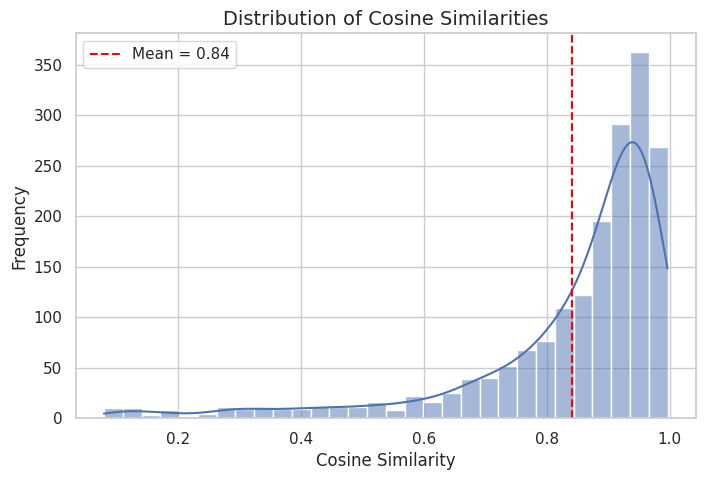

In [8]:
# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(similarities, bins=30, kde=True)
plt.title("Distribution of Cosine Similarities", fontsize=14)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.axvline(np.mean(similarities), color='red', linestyle='--', label=f"Mean = {np.mean(similarities):.2f}")
plt.legend()
plt.show()

## Question 6

In [14]:
# Initialize ROUGE scorer
rouge_scorer = Rouge()
rouge_1_f1_scores = []

for _, row in df.iterrows():
    try:
        scores = rouge_scorer.get_scores(row["answer_llm"], row["answer_orig"])[0]
        rouge_1_f1_scores.append(scores["rouge-1"]["f"])
    except Exception:
        # Handle edge cases with empty or bad inputs
        rouge_1_f1_scores.append(0.0)

avg_rouge_1_f1 = sum(rouge_1_f1_scores) / len(rouge_1_f1_scores)
print(f"Average ROUGE-1 F1 Score: {avg_rouge_1_f1:.2f}")

Average ROUGE-1 F1 Score: 0.35
